In [12]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 

In [13]:
df=pd.read_csv('../csv_data/modelling_ready_sales_data.csv')
df.head()

,id,price_per_unit,units_sold,total_revenue,year,month,weekday
0,1,50.5466,0,0.000,2023,1,6
1,2,52.1932,0,0.000,2023,1,0
2,3,49.0970,9,441.873,2023,1,1
3,4,52.6075,0,0.000,2023,1,2
4,5,50.1827,0,0.000,2023,1,3


In [15]:


numerical_features = ['price_per_unit', 'units_sold', 'total_revenue', 'month']
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])
print(df.head())


   id  price_per_unit  units_sold  total_revenue  year  month  weekday
0   1        0.569560    0.000000       0.000000  2023    0.0        6
1   2        0.632011    0.000000       0.000000  2023    0.0        0
2   3        0.514581    0.035019       0.048131  2023    0.0        1
3   4        0.647725    0.000000       0.000000  2023    0.0        2
4   5        0.555759    0.000000       0.000000  2023    0.0        3


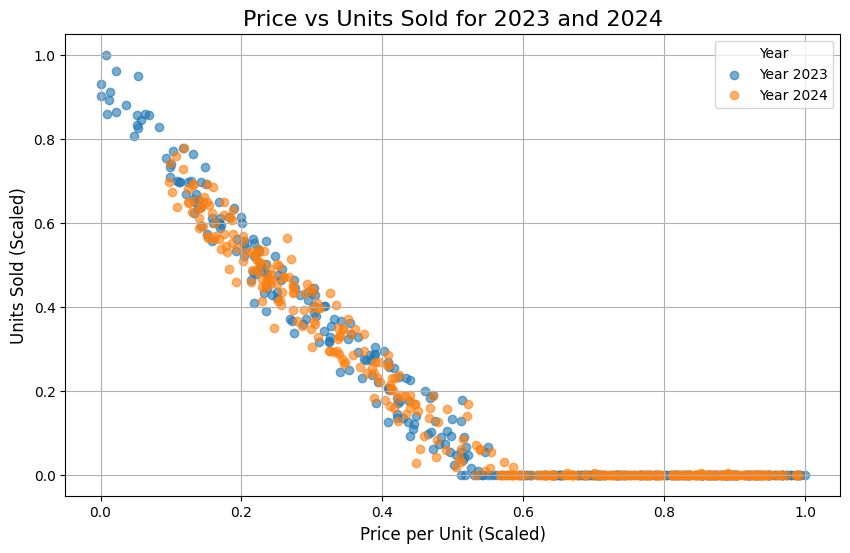

In [16]:

df_filtered = df[df['year'].isin([2023, 2024])]

plt.figure(figsize=(10, 6))
for year in [2023, 2024]:
    year_data = df_filtered[df_filtered['year'] == year]
    plt.scatter(year_data['price_per_unit'], year_data['units_sold'], label=f'Year {year}', alpha=0.6)

# Adding labels and title
plt.title('Price vs Units Sold for 2023 and 2024', fontsize=16)
plt.xlabel('Price per Unit (Scaled)', fontsize=12)
plt.ylabel('Units Sold (Scaled)', fontsize=12)
plt.legend(title='Year')
plt.grid(True)

# Show the plot
plt.show()


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              736 non-null    int64  
 1   price_per_unit  736 non-null    float64
 2   units_sold      736 non-null    float64
 3   total_revenue   736 non-null    float64
 4   year            736 non-null    float64
 5   month           736 non-null    float64
 6   weekday         736 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 40.4 KB


**Negative Correlation:** The scatter plot clearly demonstrates a strong negative correlation between "Price per Unit" and "Units Sold" for both 2023 and 2024. As the price per unit increases, the number of units sold generally decreases, which aligns with the fundamental economic principle of demand and supply.

* **Year-over-Year Comparison:**
    * There appears to be some variation in the relationship between price and units sold across the two years. 
    * The data points for 2023 and 2024 seem to exhibit slightly different patterns. A more in-depth analysis, such as calculating separate correlation coefficients for each year, would be necessary to quantify these differences.

* **Potential Outliers:**
    * A few potential outliers are visible in the plot, which deviate significantly from the overall trend. These outliers could represent unusual events or anomalies that warrant further investigation.